In [17]:
from matplotlib import pyplot as plt
import numpy as np

In [18]:
SEED_LIST = [0, 1, 2, 3]


def transform_data(data, batch_size):
    num_batches = len(data) // batch_size
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        max_value = data[:end_idx].max()
        data[start_idx:end_idx] = max_value
    return data

def load_data(alg, task, dim, n_init, batch_size, max_evals, num_evals=None ):
    data = []
    if num_evals == None:
        num_evals = max_evals
    for seed in SEED_LIST:
        data.append(np.load(f'./results/{alg}/{alg}_{task}_{dim}_{seed}_{n_init}_{max_evals}_{num_evals}.npy').reshape(-1))
        # cut off the data to the max_evals
        data[-1] = data[-1][:max_evals]
        # data[-1] = transform_data(data[-1], batch_size= batch_size)
        data[-1] = np.maximum.accumulate(data[-1])
    return np.array(data)

def pibo_load_data(alg, task, dim, n_init, batch_size, max_evals, num_evals=None, buffer_size=500, local_search_epochs= None):
    data = []
    if num_evals == None:
        num_evals = max_evals
    for seed in SEED_LIST:
        if local_search_epochs is None:
            if task in ['Ackley', 'Levy', 'Rastrigin', 'Rosenbrock']:
                data.append(np.load(f'./results/{alg}/{alg}_{task}_{dim}_{seed}_{n_init}_{batch_size}_{max_evals}_{num_evals}_{buffer_size}.npy').reshape(-1))
            else:
                data.append(np.load(f'./results/{alg}/{alg}_{task}_{dim}_{seed}_{n_init}_{batch_size}_{buffer_size}_{max_evals}_{num_evals}.npy').reshape(-1))
        else:
            data.append(np.load(f'./results/{alg}/{alg}_{task}_{dim}_{seed}_{n_init}_{batch_size}_{buffer_size}_{local_search_epochs}_{max_evals}_{num_evals}.npy').reshape(-1))
        data[-1] = data[-1][:max_evals]
        #data[-1] = transform_data(data[-1], batch_size= batch_size)
        data[-1] = np.maximum.accumulate(data[-1])
    return np.array(data)

def plot_with_std(data, label, alpha=0.2):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=alpha)

In [19]:
task_settings = { # dim, n_init, batch_size, max_evals, buffer_size, local_search_epochs (10 as default)
    'Ackley_200' : (200, 200, 100, 10000, 500, None), 
    'Ackley_400' : (400, 200, 100, 10000, 500, None),
    'Levy_200' : (200, 200, 100, 10000, 500, None),
    'Levy_400' : (400, 200, 100, 10000, 500, None),
    'Rastrigin_200' : (200, 200, 100, 10000, 1000, None),
    'Rastrigin_400' : (400, 200, 100, 10000, 1000, None),
    'Rosenbrock_200' : (200, 200, 100, 10000, 500, None),
    'Rosenbrock_400' : (400, 200, 100, 10000, 500, None),
    'HalfCheetah_102' : (102, 100, 50, 2000, 300, None),
    'RoverPlanning_100' : (100, 100, 50, 2000, 300, 30),
    'DNA_180' : (180, 100, 50, 2000, 300, 50),
}

def load_data_all(alg):
    alg_dict = {}
    for task, (dim, n_init, batch_size, max_evals, buffer_size, local_search_epochs) in task_settings.items():
        try:
            task_name = task.split('_')[0]         
            if alg == 'pibo':
                alg_dict[f'{alg}_{task}'] = pibo_load_data(alg, task_name, dim, n_init, batch_size, max_evals, buffer_size=buffer_size, local_search_epochs=local_search_epochs)
            else:
                if alg == 'mcmcbo' and dim==400 and max_evals != 2000:
                    max_evals = 6000
                alg_dict[f'{alg}_{task}'] = load_data(alg, task_name, dim, n_init, batch_size, max_evals)
        except:
            pass
    return alg_dict

pibo_list = load_data_all('pibo')
turbo_list = load_data_all('turbo')
mcmcbo_list = load_data_all('mcmcbo')
lamcts_list = load_data_all('lamcts')
ddom_list = load_data_all('ddom')
diffbbo_list = load_data_all('diffbbo')
cmaes_list = load_data_all('cmaes')
mins_list = load_data_all('mins')
cbas_list = load_data_all('cbas')
cmaes_bo_list = load_data_all('cmaes-bo')
cmaes_turbo_list = load_data_all('cmaes-turbo')

In [20]:
import pandas as pd
# algs_list = ['turbo', 'mcmcbo', 'lamcts', 'cmaes-bo', 'cbas', 'mins', 'ddom', 'diffbbo', 'cmaes', 'pibo']
algs_list = ['turbo', 'mcmcbo', 'lamcts', 'cmaes-bo', 'cbas', 'mins', 'ddom', 'diffbbo', 'cmaes', 'pibo']

task_list_1 = ['Ackley_200', 'Ackley_400', 'Rastrigin_200',  'Rastrigin_400', 'Rosenbrock_200', 'Rosenbrock_400', 'Levy_200', 'Levy_400']
task_list_2 = ['HalfCheetah_102', 'RoverPlanning_100', 'DNA_180']
task_list = task_list_1 + task_list_2


data_shape = (len(task_list), len(algs_list))
mean_max_table = pd.DataFrame(np.zeros(data_shape), index=[task for task in task_list], columns=algs_list)

# # ADD seed mean, than its max to each value
for task in task_list:
    for alg in algs_list:
        try:
            if alg == 'cmaes-bo':
                data = eval(f'cmaes_bo_list')[f'cmaes-bo_{task}']
            elif alg == 'cmaes-turbo':
                data = eval(f'cmaes_turbo_list')[f'cmaes-turbo_{task}']
            else:
                data = eval(f'{alg}_list')[f'{alg}_{task}']
            mean_max_table.loc[task, alg] = np.round(data.mean(axis=0).max(), 3)
        except:
            mean_max_table.loc[task, alg] = 'ongoing'
        
mean_max_table

/tmp/ipykernel_3426470/2610846008.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ongoing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_max_table.loc[task, alg] = 'ongoing'


,turbo,mcmcbo,lamcts,cmaes-bo,cbas,mins,ddom,diffbbo,cmaes,pibo
Ackley_200,-5.219,-2.350,-9.868000e+00,-1.685,-9.340,-8.658,-6.565,-6.727,-10.120,-0.643
Ackley_400,-7.950,-3.953,-1.128300e+01,-3.895,-10.006,-9.014,-10.749,-11.481,-10.479,-1.301
Rastrigin_200,-950.376,-1042.723,-2.403119e+03,-1716.421,-1956.072,-2482.616,-1727.235,-1730.651,-2067.872,-585.859
Rastrigin_400,-3127.963,-4673.692,-5.606082e+03,-4008.27,-4062.022,-4537.283,-4434.316,-4654.566,-4811.490,-1931.032
Rosenbrock_200,-146089.854,-28755.360,-3.594994e+06,-608.612,-1371592.517,-1474265.703,-259535.031,-247970.358,-3202046.076,-829.716
Rosenbrock_400,-2063371.380,-505349.737,-1.337136e+07,-11746.013,-4349616.315,-3074894.646,-6452494.103,-9758871.347,-5683077.034,-3948.595
Levy_200,-138.730,-150.676,-9.078970e+02,-6.821,-333.106,-690.532,-80.280,-93.750,-105.879,-11.556
Levy_400,-732.761,-885.320,-2.427986e+03,-80.561,-741.521,-1120.994,-1138.191,-1713.488,-870.321,-28.629
HalfCheetah_102,-728.860,-367.622,-4.557070e+02,ongoing,-119.512,-635.918,1269.541,1908.182,-565.867,3195.885
RoverPlanning_100,2.122,3.316,-1.481000e+00,ongoing,-6.557,-8.855,2.162,1.481,1.172,3.925


In [21]:
# # Baseline
# baseline = pibo_list['pibo_Ackley_200']
# buffer_list = [500, 1000, 2000, 5000]
# def load_buffer_abalations(buffer_list, seed_list):
#     temp = {
#         '500': [],
#         '1000': [],
#         '2000': [],
#         '5000': [],
#        # '10000': []
#     }
#     for buffer_size in buffer_list:
#         for seed in seed_list:
#             temp[f'{buffer_size}'].append(np.maximum.accumulate(np.load(f'./results/abalations/Buffer/pibo_{buffer_size}_Ackley_200_{seed}_200_10000_10000.npy').reshape(-1)))
            
#     return temp

# buffer_abalations = load_buffer_abalations(buffer_list, SEED_LIST)

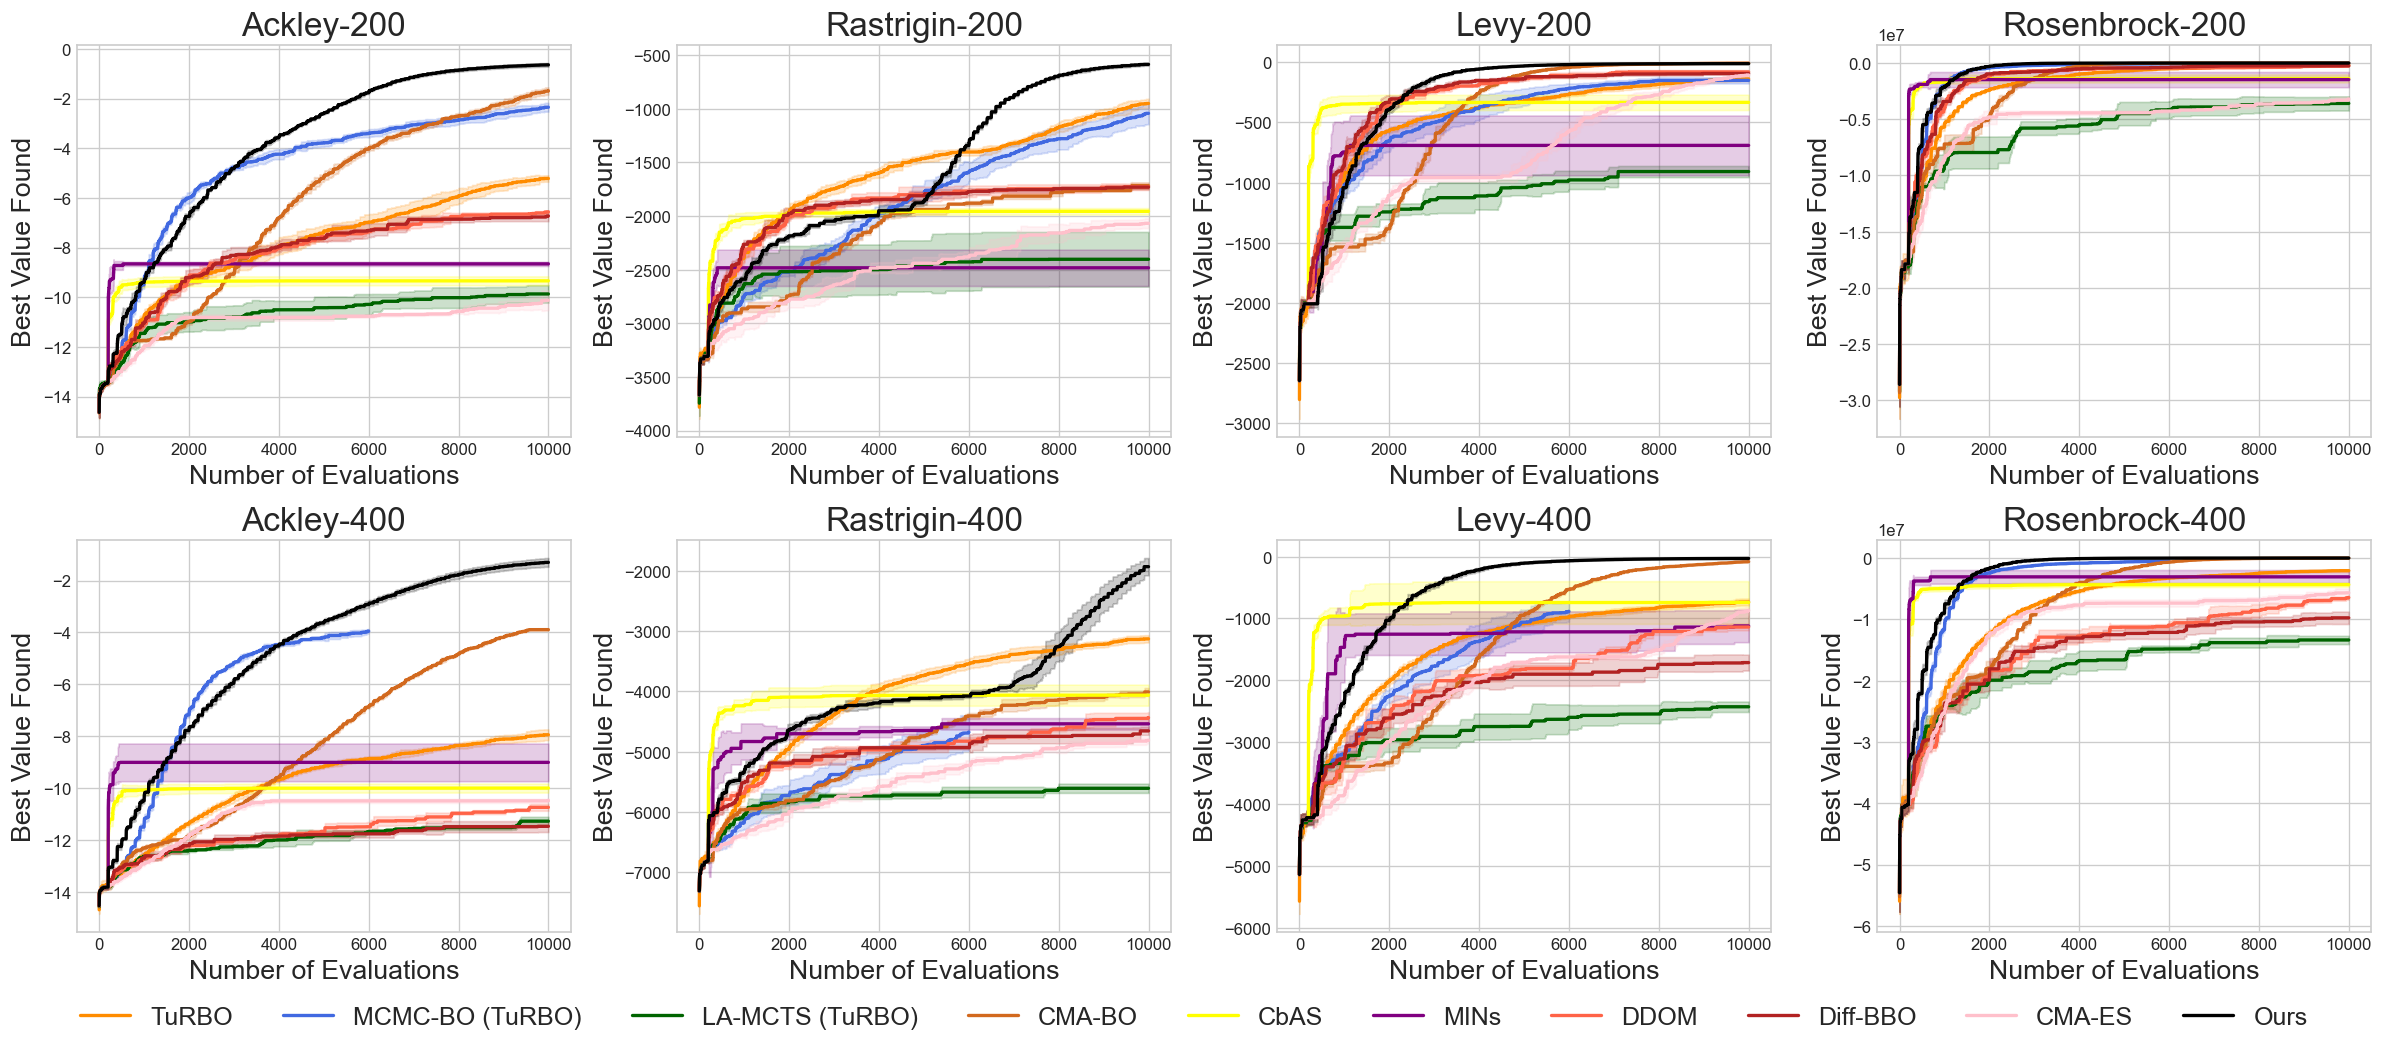

In [22]:
task = ['Ackley', 'Rastrigin', 'Levy', 'Rosenbrock']
dims = [200, 400]
algs_list = ['turbo', 'mcmcbo', 'lamcts', 'cmaes-bo','cbas', 'mins', 'ddom', 'diffbbo', 'cmaes', 'pibo']
names = ["TuRBO", "MCMC-BO (TuRBO)", "LA-MCTS (TuRBO)", "CMA-BO", "CbAS", "MINs", "DDOM", "Diff-BBO", "CMA-ES", "Ours"]
colors = ["darkorange", "royalblue", "darkgreen", "chocolate", "yellow", "purple", "tomato", "firebrick", "pink", "black"]
data_list = [turbo_list, mcmcbo_list, lamcts_list, cmaes_bo_list, cbas_list, mins_list, ddom_list, diffbbo_list, cmaes_list, pibo_list]


plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(len(dims), len(task), figsize=(20.0, 8.4), dpi = 120)
plt.subplots_adjust(hspace=0.3)
for i in range(len(dims)):
    for j in range(len(task)):
        for k in range(len(algs_list)):
            try:
                data = data_list[k][f'{algs_list[k]}_{task[j]}_{dims[i]}']
                # print(f'{algs_list[k]}_{task[j]}_{dims[i]}')
                mean = data.mean(axis=0)
                std = data.std(axis=0)
                ax[i, j].plot(mean, label=names[k], color=colors[k], linewidth=2.0)
                ax[i, j].fill_between(range(len(mean)), mean - std, mean + std, color=colors[k], alpha=0.2)
                ax[i, j].set_title(f"{task[j]}-{dims[i]}", fontsize=20)
                ax[i, j].set_xlabel("Number of Evaluations", fontsize=16)
                ax[i, j].set_ylabel("Best Value Found", fontsize=16)
            except:
                print(f'{algs_list[k]}_{task[j]}_{dims[i]}')
                ax[i, j].plot([], [], label=names[k], color=colors[k])  # 빈 plot 추가

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(algs_list), fontsize=15, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()



cmaes-bo_HalfCheetah_102
cmaes-bo_RoverPlanning_100
cmaes-bo_DNA_180


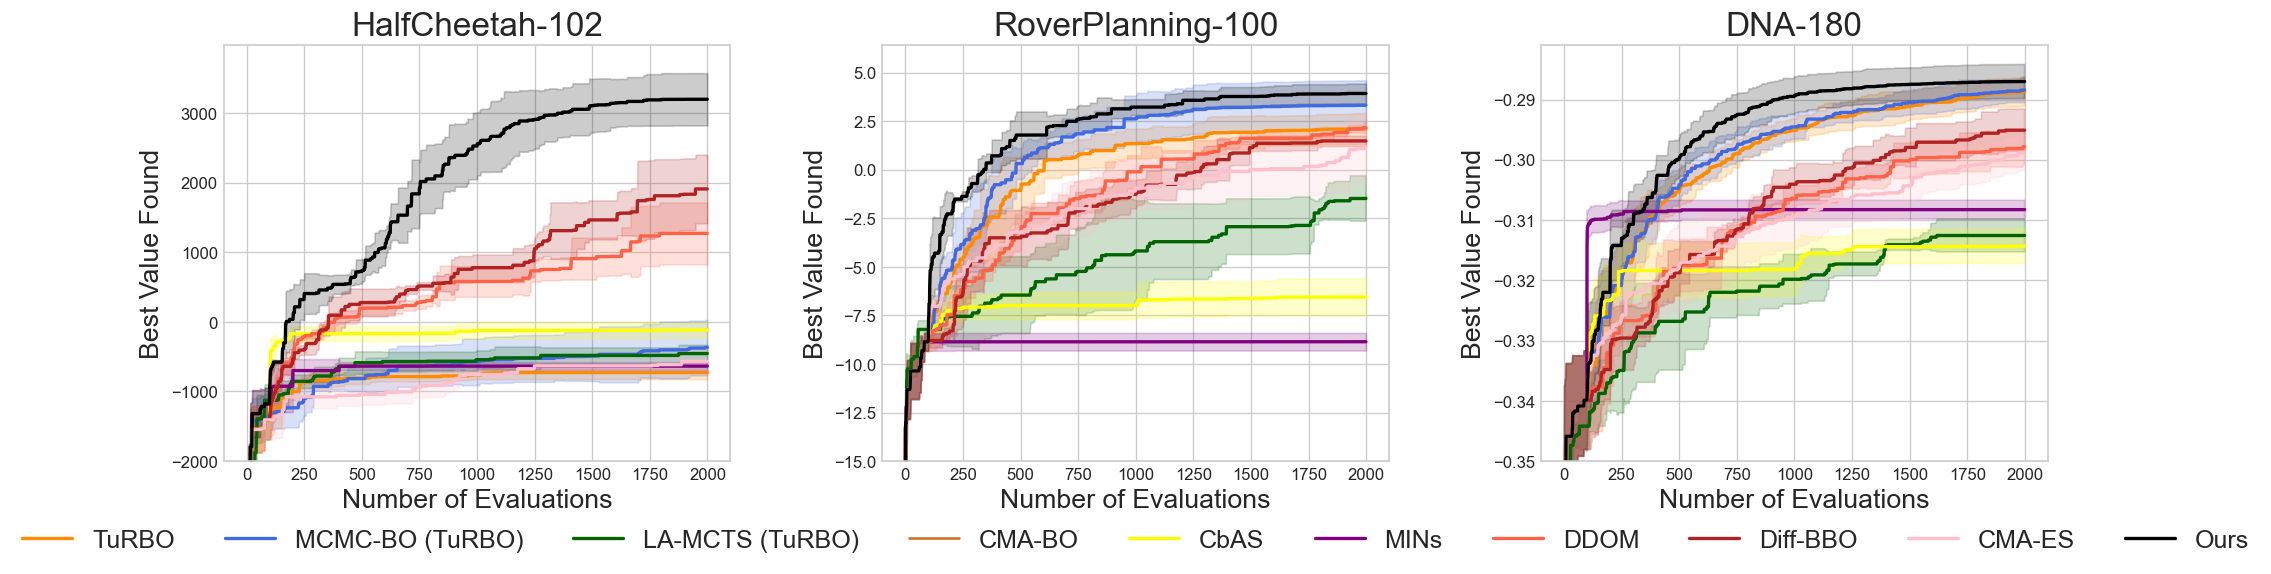

In [23]:
task = ['HalfCheetah','RoverPlanning', 'DNA']
dims = [102, 100,  180]
y_lower = [-2000, -15, -0.350]
y_upper = [None, None, -0.281]


plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(1, len(task), figsize=(20.0, 4.5), dpi=120)
plt.subplots_adjust(wspace=0.3, left=0.12, right=0.88)
for i in range(len(task)):
    for k in range(len(algs_list)):
        try:
            data = eval(f'{algs_list[k]}_list')[f'{algs_list[k]}_{task[i]}_{dims[i]}']
            mean = data.mean(axis=0)
            std = data.std(axis=0)
            ax[i].plot(mean, label=names[k], color=colors[k], linewidth=2.0)
            ax[i].fill_between(range(2000), mean - std, mean + std, color=colors[k], alpha=0.2)
        except:
            print(f'{algs_list[k]}_{task[i]}_{dims[i]}')
            ax[i].plot([], [], label=names[k], color=colors[k])
    ax[i].set_title(f"{task[i]}-{dims[i]}", fontsize=20)
    ax[i].set_xlabel("Number of Evaluations", fontsize=16)
    ax[i].set_ylabel("Best Value Found", fontsize=16)
    ax[i].set_ylim(y_lower[i], y_upper[i])
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(algs_list), fontsize=15, bbox_to_anchor=(0.5, -0.1))


Abalations

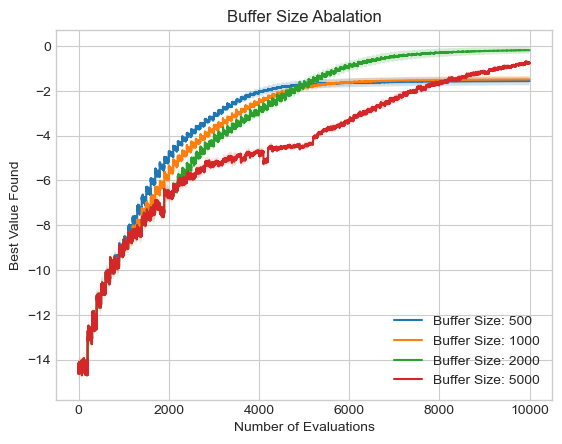

In [679]:
for buffer_size in buffer_list:
    data = np.array(buffer_abalations[f'{buffer_size}'])
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    plt.plot(mean, label=f'Buffer Size: {buffer_size}')
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)
    plt.title('Buffer Size Abalation')
    plt.xlabel("Number of Evaluations")
    plt.ylabel("Best Value Found")
    plt.legend()